In [1]:
from numba import float32,int32,int8,jit,cuda,int64
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32,xoroshiro128p_uniform_float64
from numba.cuda.random import xoroshiro128p_normal_float32
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import math
from util import *

# Making a checkerboard

I just wanted to verify that using i xor j generates a checkerboard for i,j $\in$ {0,1}

The concept here is to make a large checkerboard by breaking a board into 2x2 pieces then making
each 2x2 piece a checkerboard by taking i xor j.

This works because the truth table for xor looks like a checkerboard.

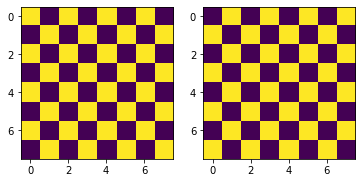

In [2]:
@cuda.jit
def checkerpattern(grid,side):
    x=cuda.threadIdx.x
    y=cuda.threadIdx.y
    for i in range(2):
        j = i^side
        grid[2*x+i][2*y+j]=1
        
fig,axs = plt.subplots(1,2)        
#checkerboard where the first 0 is in the bottom left
grid = np.zeros([8,8])

#checkerpattern is called with threads as half of the array dimension in both x and y
checkerpattern[(1,1),(4,4)](grid,0)
axs[0].imshow(grid)
#checkerboard where the first 1 is in the bottom left
grid = np.zeros([8,8])
checkerpattern[(1,1),(4,4)](grid,1)
axs[1].imshow(grid)
plt.show()

# Ising Updates

You are given an interaction energy J and magnetic constant h

Entries in $J_{ij}$ are zero if i and j aren't neighbors and J if they are (in the upper triangle) and zero in the lower triangle

We then do updates according to the metropolis algorithm with the ising hamiltonian.

Note this interaction only depends on nearest neighbors so you can update half of the lattice (in a checkerboard) simultaneously since these updates are independent

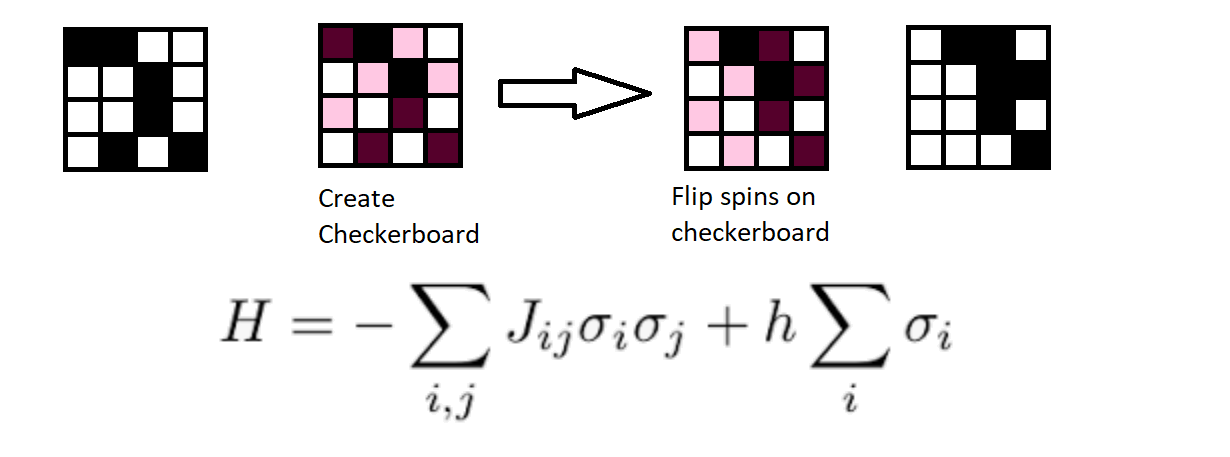

Note: $\sigma_{ij}$ are 1 or -1 for spin up/down

Changing a spin $\sigma_{a}$ to $-\sigma_{a}$ will then result in an energy difference of

$\Delta H = H_2-H_1 = \big[-\sum_{ij} J_{ij} \sigma_i \sigma_j (1-2\delta_{ia}) + h\sum_i\sigma_i(1-2\delta_{ia})\big] - \big[-\sum_{ij} J_{ij} \sigma_i \sigma_j + h\sum_i\sigma_i\big]$

$\Delta H = -\sum_{ij}[ J_{ij} \sigma_i \sigma_j (1-2\delta_{ia}) - J_{ij} \sigma_i \sigma_j] + h\sum_i[\sigma_i(1-2\delta_{ia}) - \sigma_i]$

$\Delta H = -\sum_{ij}  -2\delta_{ia}J_{ij}\sigma_i \sigma_j  + h\sum_i-2\delta_{ia}\sigma_i$

$\Delta H = \sum_{j} 2J_{aj}\sigma_a \sigma_j  - 2h\sigma_a$

$\Delta H = 2\sigma_a \big(\sum_{j}(J_{aj} \sigma_j)  -h\big)$


Here $\sum_{j}(J_{aj} \sigma_j)$ is just going to be the sum the spins of your neighbors of $\sigma_a$

In [3]:
@cuda.jit(device=True)
def localIsingUpdate2D(grid,i,j,J,h,n):
    """Computes a local ising update at position i,j
       Parameters:
           grid (2d int array)   - the spin values
           i,j  (integers)       - x and y positions on the grid
           J,h  (float)          - Bond energy and magnetic constant
           n    (float on [0,1]) - Random number
    """
    #get 2d grid dimensions
    sx,sy=grid.shape
    #get number of spin-up neighbors
    up_neighbors=grid[(i+1)%sx][j]+grid[(i-1)%sx][j]+grid[i][(j+1)%sy]+grid[i][(j-1)%sy]
    #since data is 0 or 1 instead of -1 or 1 we have map 0 to -1 and 1 to 1 (take 2x-1)
    spin=2*grid[i][j]-1
    #same thing but there are 4 spins so we take 4x-4
    neighbor_sum = up_neighbors*2-4
    #calculate energy difference
    dH = 2*spin*(neighbor_sum*J-h) 
    
    #probability of a spin flip according to the metropolis algorithm
    probability = min(1,math.exp(-dH))
    # Perform the spin flip
    if 1-n < probability:
        grid[i][j]=1-grid[i][j]

@cuda.jit
def isingUpdate2D(grids,J,h,steps,rng):
    """ Function to do 2D ising updates on an array of 2D grids. Each block covers one grid
    and the the number of threads should fill a quarter of the grid. So calling a set of grids
    of shape [N,X,Y] should have blocks = [1,1,N] and threads = [X/2,Y/2,1] 
    
    Parameters:
       grids (3d int array)  - the spin values
       J,h  (float)          - Bond energy and magnetic constant
       rng (object)          - The random state initialization
    
    """
    #Need to add a chance of doing nothing so we can access the entire state space in the 
    #infinite temperature limit
    P=0.8
    
    z=cuda.blockIdx.z
    x=cuda.threadIdx.x
    y=cuda.threadIdx.y
    Sz,Sx,Sy=grids.shape
    
    #give each thread a unique id
    myid=(z*Sy+y)*Sx+x

    #create shared memory for this block
    checker= cuda.shared.array(1, int8)
    #we have steps*5 because breaking it into 2x2 grids gives a 1/4 chance of updating a cell
    #then there is a 4/5 conditional chance it's actually updated because P is fixed at 0.8
    #so in all each cell has a 1/5 chance of an update - so for each cell to on average be updated
    #once, we need to do 5 steps
    for step in range(steps*5):
        #must sync the threads here so the checkerboard is the same for the whole block
        cuda.syncthreads()
        if x==0 and y==0:
            checker[0] = int(xoroshiro128p_uniform_float32(rng,myid)+0.5)
            #randomly select which checkerboard to use
        cuda.syncthreads()
        
        #randomly select one of two available positions on our 2x2 checkerboard
        
        if xoroshiro128p_uniform_float32(rng,myid)>P:
            continue
        
        i = int(xoroshiro128p_uniform_float32(rng,myid)+0.5)
        # the ^ symbol is for xor
        
        j = i^checker[0]
        n = xoroshiro128p_uniform_float32(rng,myid)
        #perform our local ising update
        localIsingUpdate2D(grids[z],2*x+i,2*y+j,J,h,n)
        
    

# Making a Class to run Ising Simulations

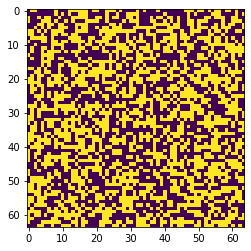

Canvas(height=256, width=256)

In [4]:
class Ising(Thread):
    """Class to run Ising simulations.
    grids is the store of 2D lattice states on the gpu and changes as you run the sim
    state is a property function which copies grids to the cpu and will remain static
    """
    def __init__(self,JB,N=1,skip=1):
        """Parameters:
            JB (float) - The bond energy multiplied by the boltzmann constant used in the sim
            N (int)    - The number of 2D simulations to run in parallel
            skip (int) - The number of ising updates per cell to be done in a single kernel call
            """
        self.grids = cuda.to_device(np.zeros([N,64,64],dtype=np.int8))
        self.rng = create_xoroshiro128p_states(self.grids.size,seed=np.random.randint(100000))
        self.JB=JB
        self.skip=skip
        super(Ising,self).__init__()
    def step(self):
        isingUpdate2D[(1,1,1),(32,32,1)](self.grids,self.JB,0.0,self.skip,self.rng)
    @property
    def state(self):
        return self.grids.copy_to_host()

cleaner.hard_reset()
canvas = Canvas(width=256, height=256)

model = Ising(0.4407,skip=1)

#make sure it looks random in the infinite temperature limit
isingUpdate2D[(1,1,1),(32,32,1)](model.grids,0.0,0.0,100,model.rng)
plt.imshow(model.state[0])
plt.show()


rend = Render(model.grids,canvas,[256,256,3],binary=True)
model.start()
time.sleep(1)
rend.start()
canvas

In [5]:
print(model.fps())
cleaner.hard_reset()

7880


# Functions to make a compact dataset

The idea it to store the data such that each spin value only takes up a bit of space. The storage should also easily be turned into an 'unraveled' set of spins to be fed into an rnn

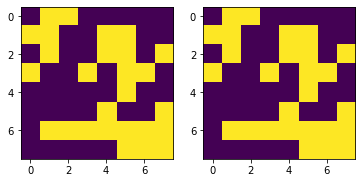

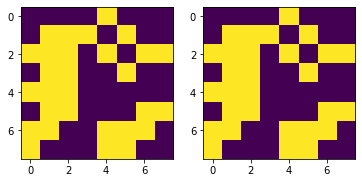

In [6]:
@cuda.jit
def compress(states,out,startidx):
    """Squish each state into a 1D array in a snake pattern then
    compress it by turning each set of 8 values into a uint8. For example, a 32x32 grid would
    mean you have 128 uint8s
    
    If states has shape [N,X,Y] then out should have shape [M,X*Y/8]
    and the blocks/threads should have shape [N,X*Y/8]
    
    """
    sz,sx,sy=states.shape
    #n is which 2d grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the 2d grid
    state=states[n]
    num=0
    for bit in range(8):
        idx=i*8+bit
        x = idx//sy
        y = idx%sy
        #make it a snake pattern. . .
        if x%2==1:
            y=sy-y-1
        if state[x][y]==1:
            num+=1<<bit
    out[n+startidx][i]=num
@cuda.jit
def decompress2D(inn,states):
    """Inverse function of compress"""
    sz,sx,sy=states.shape
    #n is which 2d grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the 2d grid
    state=states[n]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        x = idx//sy
        y = idx%sy
        #make it a snake pattern. . .
        if x%2==1:
            y=sy-y-1
        state[x][y]=1&(num>>bit)

@cuda.jit
def decompress1D(inn,states):
    """Similar to decompress 2D but instead of being an inverse to compress it squishes the 2D
    array output into a 1D array (which is now in a snake pattern)
    if states has shape [N,X] then out should have shape [M,Z/8]
    and the blocks/threads should have shape [N,Z/8]
    Here Z=X*Y where each state has shape [X,Y] on a 2D grid
    
    """
    #n is which grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the grid
    state=states[n]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        #get each value in 1d
        state[idx]=1&(num>>bit)

N=8
        
a = np.random.random([2,N,N])>0.6
store=np.zeros([2,N*N//8],dtype=np.uint8)
compress[(2,N//2),(1,N//4)](a,store,0)
b = np.zeros([2,N,N],dtype=np.uint8)
c = np.zeros([2,N*N],dtype=np.uint8)
decompress2D[(2,N//2),(1,N//4)](store,b)
decompress1D[(2,N//2),(1,N//4)](store,c)
fig,axs = plt.subplots(1,2)        
axs[0].imshow(a[0])
axs[1].imshow(b[0])
plt.show()

fig,axs = plt.subplots(1,2)        
axs[0].imshow(a[1])
axs[1].imshow(b[1])
plt.show()

plt.imshow(c)
plt.axis('off')
plt.show()

# Using our Ising simulations to generate traindata

In [7]:
def generate_states(nstates,skip,nsim,size,JB,save=True):
    """Run an Ising sim at a given temp and compress the states and return them"""
    assert nstates%nsim==0
    store=cuda.to_device(np.zeros([nstates,size*size//8],dtype=np.uint8))
    states = cuda.to_device(np.zeros([nsim,size,size],dtype=np.uint8))
    rng = create_xoroshiro128p_states(states.size,seed=np.random.randint(100000))
    
    isingUpdate2D[(1,1,nsim),(size//2,size//2,1)](states,0.0,0.0,skip,rng)
    isingUpdate2D[(1,1,nsim),(size//2,size//2,1)](states,JB,0.0,skip*10,rng)
    for idx in range(nstates//nsim):
        isingUpdate2D[(1,1,nsim),(size//2,size//2,1)](states,JB,0.0,skip,rng)
        compress[(nsim,size//2),(1,size//4)](states,store,nsim*idx)
    out = store.copy_to_host()
    if save==True:
        np.save('data/traindata%d-%d.npy'%(size,JB*10000),out)
    return out



# 32x32 traindata

In [12]:
t=time.time()
data=generate_states(512*10**5,20,512,32,0.4407)
print(int(time.time()-t),data.shape,np.mean(data))

233 (51200000, 128) 127.04459056869507


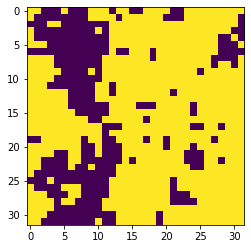

In [21]:
tst=np.zeros([1,32,32],dtype=np.int8)
N=32
idx=2638
decompress2D[(1,N//2),(1,N//4)](data[idx:idx+1],tst)
plt.imshow(tst[0])
plt.show()

In [8]:
t=time.time()
data=generate_states(512*10**5,20,512,32,0.3407)
print(int(time.time()-t),data.shape,np.mean(data))

263 (51200000, 128) 127.49604906066895


# 16x16 Traindata
 The naming scheme I'm using is traindata<N><Beta*10000>< B if decorrelation is set higher>

In [ ]:
t=time.time()
data=generate_states(512*10**5,20,1024,16,0.4407)
print(int(time.time()-t),data.shape,np.mean(data))

In [15]:
t=time.time()
data=generate_states(512*10**5,20,1024,16,0.2500)
print(int(time.time()-t),data.shape,np.mean(data))

58 (51200000, 32) 127.48289624938965


# 8x8 Traindata

In [17]:
t=time.time()
data=generate_states(512*10**5,20,1024,8,0.4407)
print(int(time.time()-t),data.shape,np.mean(data))



97 (51200000, 8) 127.42567258544922


In [ ]:
t=time.time()
data=generate_states(512*10**5,20,1024,8,0.3407)
print(int(time.time()-t),data.shape,np.mean(data))

In [23]:
t=time.time()
data=generate_states(512*10**5,20,1024,8,0.15)
print(int(time.time()-t),data.shape,np.mean(data))

33 (51200000, 8) 127.49593698486328


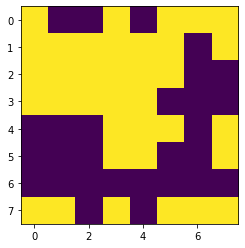

In [10]:
tst=np.zeros([1,8,8],dtype=np.int8)
N=8
idx=2638
decompress2D[(1,N//2),(1,N//4)](data[idx:idx+1],tst)
plt.imshow(tst[0])
plt.show()

# Modifying the Ising updates to target a specific energy

In [8]:
@cuda.jit(device=True)
def IsingTarget2D(grid,i,j,J,n,E,target):
    """Computes a local ising update at position i,j
       Parameters:
           grid (2d int array)   - the spin values
           i,j  (integers)       - x and y positions on the grid
           J  (float)            - Temperature (assumed bond energy is 1)
           n    (float on [0,1]) - Random number
           target (int)         - A target energy
    """
    #get 2d grid dimensions
    sx,sy=grid.shape
    #get number of spin-up neighbors
    up_neighbors=grid[(i+1)%sx][j]+grid[(i-1)%sx][j]+grid[i][(j+1)%sy]+grid[i][(j-1)%sy]
    #since data is 0 or 1 instead of -1 or 1 we have map 0 to -1 and 1 to 1 (take 2x-1)
    spin=2*grid[i][j]-1
    #same thing but there are 4 spins so we take 4x-4
    neighbor_sum = up_neighbors*2-4
    #calculate energy difference
    dH = 2*spin*(neighbor_sum) 
    
    #this will actually make the energy estimates slightly out of date since
    #other threads can update energy between when we take E[0] and atomic add to E[0]
    current=E[0]
    new=int(E[0]+dH)
    move=abs(current+dH-target)-abs(current-target)
    
    #probability of a spin flip according to the metropolis algorithm
    probability = min(1,math.exp(-move)*J)
    # Perform the spin flip
    # We add a secondary condition with compare and swap to avoid using an out of date energy 
    if 1-n < probability and cuda.atomic.compare_and_swap(E,current,new)==current:
        grid[i][j]=1-grid[i][j]

@cuda.jit
def isingTargeter2D(grids,J,steps,rng,targets):
    """ Function to do 2D ising updates on an array of 2D grids. Each block covers one grid
    and the the number of threads should fill a quarter of the grid. So calling a set of grids
    of shape [N,X,Y] should have blocks = [1,1,N] and threads = [X/2,Y/2,1] 
    
    Parameters:
       grids (3d int array)  - the spin values
       J  (float)            - Temperature (assumed bond energy is 1)
       rng (object)          - The random state initialization
       targets (int array)   - A set of target energies
    
    """
    #Need to add a chance of doing nothing so we can access the entire state space in the 
    #infinite temperature limit
    P=0.8
    
    z=cuda.blockIdx.z
    x=cuda.threadIdx.x
    y=cuda.threadIdx.y
    Sz,Sx,Sy=grids.shape
    
    #give each thread a unique id
    myid=(z*Sy+y)*Sx+x

    #create shared memory for this block
    checker= cuda.shared.array(1, int8)
    if x==0 and y==0:
        checker[0] = int(xoroshiro128p_uniform_float32(rng,myid)+0.5)
    cuda.syncthreads()
    
    #set it to all up or all down so we know we are at ground state
    grids[z][2*x][2*y] = grids[z][2*x+1][2*y]=grids[z][2*x][2*y+1]=grids[z][2*x+1][2*y+1]=checker[0]
      
    E = cuda.shared.array(1, int64)
    E[0]=-2*Sx*Sy
    #we have steps*5 because breaking it into 2x2 grids gives a 1/4 chance of updating a cell
    #then there is a 4/5 conditional chance it's actually updated because P is fixed at 0.8
    #so in all each cell has a 1/5 chance of an update - so for each cell to on average be updated
    #once, we need to do 5 steps
    for step in range(steps*5):
        #must sync the threads here so the checkerboard is the same for the whole block
        cuda.syncthreads()
        if x==0 and y==0:
            checker[0] = int(xoroshiro128p_uniform_float32(rng,myid)+0.5)
            #randomly select which checkerboard to use
        cuda.syncthreads()
        
        #randomly select one of two available positions on our 2x2 checkerboard
        
        if xoroshiro128p_uniform_float32(rng,myid)>P:
            continue
        
        i = int(xoroshiro128p_uniform_float32(rng,myid)+0.5)
        # the ^ symbol is for xor
        
        j = i^checker[0]
        n = xoroshiro128p_uniform_float32(rng,myid)
        #perform our local ising update
        IsingTarget2D(grids[z],2*x+i,2*y+j,J,n,E,targets[z])
        


# Generating TestData
Testing with equal sized bins for each energy

In [9]:


def generate_states_with_targets(nstates,skip,targets,size,JB):
    """Run an Ising sim at a given temp and compress the states and return them"""
    nsim=targets.size
    assert nstates%nsim==0
    store=np.zeros([nstates,size*size//8],dtype=np.uint8)
    states = cuda.to_device(np.zeros([nsim,size,size],dtype=np.uint8))
    rng = create_xoroshiro128p_states(states.size,seed=np.random.randint(100000))
    
    for idx in range(nstates//nsim):
        isingTargeter2D[(1,1,nsim),(size//2,size//2,1)](states,JB,skip,rng,targets)
        compress[(nsim,size//2),(1,size//4)](states,store,nsim*idx)
    return store

In [13]:
N=32
targets=(np.arange(N*N*4)-N*N*2)[::2].copy()

data = generate_states_with_targets(targets.size*20,500,targets,N,0.95)

(2048, 32, 32)


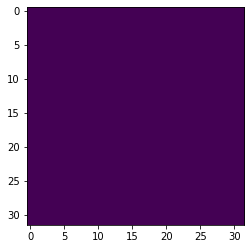

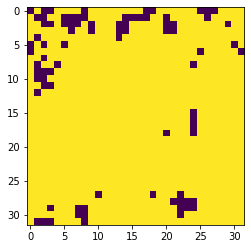

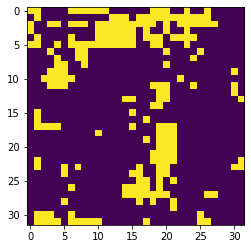

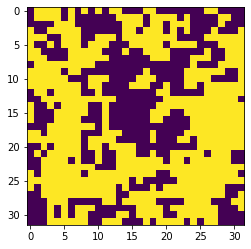

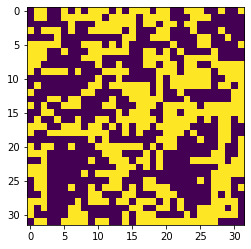

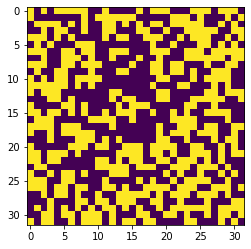

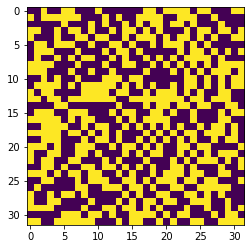

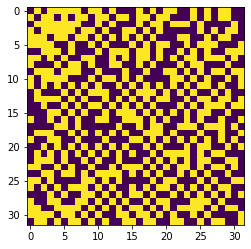

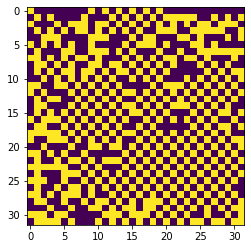

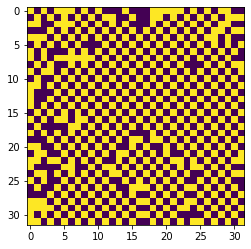

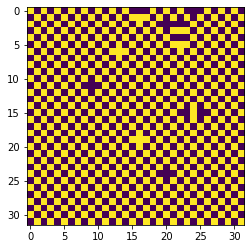

In [14]:
b=np.zeros([targets.size,N,N])
print(b.shape)
decompress2D[(targets.size,N//2),(1,N//4)](data,b)
for bi in b[::200]:
    plt.imshow(bi)
    plt.show()

In [16]:
np.save('data/testdata32',data)

In [12]:
N=16
targets=(np.arange(N*N*4)-N*N*2)[::2].copy()
data = generate_states_with_targets(targets.size*200,1000,targets,N,0.95)
np.save('data/big16',data)

In [10]:
N=8
targets=(np.arange(N*N*4)-N*N*2)[::2].copy()
data = generate_states_with_targets(targets.size*20,500,targets,N,0.95)
np.save('data/testdata8',data)

(40960, 32, 32) (40960,)


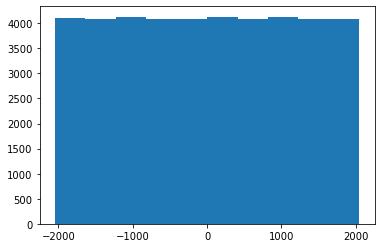

-2048.0 2048.0


In [15]:
@cuda.jit
def IsingEnergy(grids,E):
    z,i,j=cuda.grid(3)
    sz,sx,sy=grids.shape
    s1=grids[z][i][j]*2-1
    s2=grids[z][(i+1)%sx][j]*2-1
    s3=grids[z][i][(j+1)%sy]*2-1
    cuda.atomic.add(E,z,-s1*s2-s1*s3)
    
E=np.zeros(data.shape[0])
b=np.zeros([data.shape[0],N,N])
print(b.shape,E.shape)
decompress2D[(data.shape[0],N//2),(1,N//4)](data,b)
IsingEnergy[(data.shape[0],N//8,N//8),(1,8,8)](b,E)

plt.hist(E)
plt.show()
print(min(E),max(E))

In [33]:
def testforward():
    h0=-1
    c0=-1
    N=8
    #set up 2d array to strore the hidden states
    H = np.zeros([N,N])-1
    #set up the 2d array to store the passthrough?
    C = np.zeros([N,N])-1
    
    for idx in range(63):
        x = idx//N
        y = idx%N
        newrow=y
        #make it a snake pattern. . . (massive pain smh)
        if x%2==1:
            y=N-y-1
        if x==0:
            hx,cx=h0,c0
        else:
            hx,cx=H[x-1][y],C[x-1][y]
        #need to deal with snake bs now
        if newrow==0:#when there is a new row
            hy,cy=h0,c0
        else:# the direction of the previous horizontal is flipped when x%2==1
            hy,cy=H[x][y-1+2*(x%2)],C[x][y-1+2*(x%2)]
        #I'm storing all the states in 2d arrays
        C[x][y],H[x][y] = cy+1,hx+1
    print(H)
    print(C)
testforward()

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.]
 [-1.  7.  7.  7.  7.  7.  7.  7.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 7.  6.  5.  4.  3.  2.  1.  0.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 7.  6.  5.  4.  3.  2.  1.  0.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 7.  6.  5.  4.  3.  2.  1.  0.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.]
 [-1.  6.  5.  4.  3.  2.  1.  0.]]
